# MATH 100.2 Project 1: VaR for Currencies and Bonds

### Instructor: Juan Carlo F. Mallari (jmallari@ateneo.edu)

MATH 100.2: Topics in Financial Mathematics II \
First Semester, S.Y. 2022-2023 \
Ateneo de Manila University

Submitted by:
1. BELTRAN, Neil John
2. DONAIRE, Martin
3. VICTORIA, Maj

People I asked help from:

1. Jimson Paulo Layacan

Resources used for completing this project:
1. https://www.programiz.com/python-programming/examples/quadratic-roots
2. https://www.w3schools.com/python/ref_func_range.asp
3. https://realpython.com/python-complex-numbers/
4. https://stackoverflow.com/questions/32932866/numpy-the-best-way-to-remove-the-last-element-from-1-dimensional-array#:~:text=5
5. https://www.geeksforgeeks.org/how-to-calculate-correlation-between-two-columns-in-pandas/
6. https://merage.uci.edu/~jorion/oc/case5.html


### PACKAGES

In [1]:
import numpy as np # Numerical Computing
import pandas as pd # Data wrangling
import matplotlib.pyplot as plt #Plotting
import datetime as dt

from statistics import NormalDist # statistical analysis
from tabulate import tabulate #Tables
from dateutil.relativedelta import relativedelta

### PART 1: Functional Implementation

 `HELPER FUNCTIONS`


In [2]:
def linear_interp(t,x,y):
    '''
    Linearly interpolates the zero rate for tenor t 
    using the equation of line determined by the two available points 
    (x_1,y_1) and (x_2,y_2) whose tenors x_1 and x_2 are nearest to t
    
    -------
    Inputs:
    t = tenor of the unknown zero rate 
    x = list [x_1,x_2]
    y = list [y_1,y_2]
    '''
    m = (y[1]-y[0])/(x[1]-x[0])
    
    y = y[0] + m*(t-x[0])
    
    return y

In [3]:
def get_tenor(
    start_date, end_date
    ):
    """
    Calculates the tenor in years from start_date to end_date following the Actual/360 day count convention
    
    Inputs:
    start_date: start date in "yyyy-mm-dd" format (usually today)
    end_date: end date in "yyyy-mm-dd" format (coupon payment/maturity date)
    """
    
    day_count = (end_date - start_date).days
    tenor = day_count / 360.0
    
    return tenor

In [4]:
def get_DV01(start_date, maturity_date, 
    face_value, coupon_rate,
    coupon_freq, ytm
): 
    """
    A helper function for #6 and #7 that calculates the DV01 of a (plain vanilla) coupon-bearing or zero-coupon bond.
    ------
    Notes:
    1) The Actual/360 day count convention is used.
    2) The yield is assumed to be continuously compounded.
    """
    """
    Inputs:
    start_date     : start date in "yyyy-mm-dd" format (usually today)
    maturity_date  : maturity date in "yyyy-mm-dd" format
    face_value     : quantity or par value of the bond
    coupon_rate    : coupon rate in decimal form
    coupon_freq    : number of coupon payments every year (1, 2, 4, 12)
    ytm            : yield to maturity 
                     (if not given, the most recent of the each bond in the portfolio)
    Return
    -------
    float (Do not round off for an accurate VaR)
        The DV01 of a (plain vanilla) coupon-bearing or zero-coupon bond.
    """
    
    def get_tenor(start_date, maturity_date):
        
        """
        Calculates the tenor in years from start_date to end_date following the Actual/360 day count convention
    
        Inputs:
        start_date: start date in "yyyy-mm-dd" format (usually today)
        end_date: end date in "yyyy-mm-dd" format (coupon payment/maturity date)
        
        Return
        ------
        float (the tenor of each bond)
        """
        
        day_count = (maturity_date - start_date).days
        tenor = day_count / 360.0
        return tenor
    
    # Covert the dates into a compatible format
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    maturity_date = dt.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    #for the zero-bond in the porftolio
    if coupon_freq == 0:
        tenor = get_tenor(start_date, maturity_date)
        m_value = face_value*np.exp(-tenor*ytm)                           #market value
        m_price = (m_value/face_value)*100                                #market price
        m_dur = (m_price * tenor)/100                                     #modified duration
    
        DV01= (m_dur * m_value)/100**2                                    #DV01 of a bond
        
    #for the plain vanilla bond (bond with coupon payments)   
    else:
        coupon_dates = []
        coupon_date = maturity_date
        # Create list of coupon dates
        while start_date < coupon_date:
            coupon_dates.append(coupon_date)
            coupon_date -= relativedelta(months = 12 / coupon_freq)

        coupon_dates = coupon_dates[::-1] # rearrange dates
        # Create list of time values
        times = [get_tenor(start_date, t) for t in coupon_dates]

        # Create list of coupons
        coupon = (coupon_rate * face_value) / coupon_freq
        coupons = [coupon] * (len(coupon_dates) - 1)
        coupons += [coupon + face_value]

        # Create list of discount factors
        discount_factors = [np.exp(-ytm * t) for t in times]

        df = pd.DataFrame({'coupon_dates' : coupon_dates})
        df.loc[:, "t"] = times
        df.loc[:, "CF"] = coupons
        df.loc[:, "DF"] = discount_factors
        df.loc[:, "PV"] = df["CF"] * df["DF"]
        
        # Compute for the market value/ bond price
        m_value = df["PV"].sum()
        
        # Compute for the modified duration D*
        df["PVCFt"]= (df["PV"] * df["t"])
        m_dur = (df["PVCFt"].sum())/(m_value)

        DV01= (m_dur*m_value)/100**2
    
    return DV01

1. `undiversified_VaR_delta_normal_fx()`
        - Returns the undiversified d-day p% VaR of a portfolio of currencies using the Delta-Normal Approach
        - This should include the option to implement EWMA in estimating volatilities of exchange-rate returns
        - Uses N-day logarithmic returns for calculating the N-day VaR 

In [5]:
def undiversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst, F_lst, d, p, 
    ewma_par_lst=None
):
    
    """Returns the undiversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach. 
    This function uses the N-day logarithmic returns in calculating N-day VaR. 
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid quote of the currency [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        assume that there is one df per currencies in the portfolio and PHP is always the quote currency. 
    F_lst : list (of int)
        F_i = position ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith currency (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    
    Returns
    -------
    float (2 decimal places)
        undiversified d-day p% VaR of a portfolio of currency using Delta Normal Approach
    """
    
    #computes the return column for each df.
    def get_return(df):
        """
        df is the original df
        appends returns series to df
        """
        return np.log(df["Mid"] / df["previous"])

    #computes the weight column if log(returns) follows EWMA.
    def get_weights(df,d, ewma_par):
        """
        df is the original df
        appends weight series to df
        """
        count_returns= len(df["Mid"]) - d                                           #gives the number of non NaN entries
        weight_lst = [ ((1-ewma_par)*(ewma_par)**j) for j in range(count_returns)]  #calculate the weights
        df["weights"] = pd.Series(weight_lst)                                       #attach the weights as a column to the df
        return df
    
    #Case 1: I'll use the VaR with EWMA
    def get_VaR_with_EWMA(df, F , d , p , ewma_par):    #a helper function to compute the VaR (with EWMA) of each currency in the portfolio.
        
        """Returns the d-day 100(alpha)% VaR of a single currency using Delta Normal Approach with EWMA.
    
        Parameters
        ----------
        df : pandas.DataFrame
            has two columns: (1) Date [str] and (2) closing price [float]
            assumes the dates are arranged from newest to oldest, and the date today is the date on the first row  
        N : int
            number of shares for the sole currency
        d : int
            value of d for the d-day VaR
        p : int
            the value to be used in calculting the 100(alpha)% VaR (e.g. 0.99, 0.95)
        ewma_par : float
            the value of the lambda parameter in an EWMA model for the volatility of the currency
            assumes the value is in the range (0,1)

        Returns
        -------
        float
            d-day 100p% VaR of a single currency using Delta Normal Approach (with EWMA)
        """
        
        y0 = df.loc[0,"Mid"]                                  #find the recent Mid price of each currency in the portfolio.
        
        df["previous"]= df["Mid"].shift(-d)                   #shift the closing prices d up (-d down) to compute the return.
        df["return"] = df.apply(get_return, axis=1)           #computes the return
        
        df = get_weights(df, d, ewma_par)                       #obtain the weights
        variance = np.nansum(df["weights"] * (df["return"]**2)) #computes the estimated variance (weighted)
        sigma = np.sqrt(variance)                               #standard deviation of the log(returns) with EWMA 
        quantile = NormalDist().inv_cdf(p/100)                  #computes for the quantie of p%
        
        var = F * y0 * sigma * quantile                         #compute each df's VaR under this case
    
        return var
    
    #Case 2: I'll use the delta-normal VaR (without EWMA)
    def get_VaR_Normal(df, F ,d, p ):  #a helper function to compute the VaR (without EWMA par) of each currency in the portfolio.
        
        """Returns the d-day 100p% VaR of a currency using Delta Normal Approach.
    
        Parameters
        ----------
        df : pandas.DataFrame
            has two columns: (1) Date [str] and (2) Mid quote [float]
            assumes the dates are arranged from newest to oldest, and the date today is the date on the first row  
        F : int
            position of currency
        d : int
            the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)     
        p : int
            the value to be used in calculting the 100(alpha)% VaR (e.g. 0.99, 0.95)
        Returns
        -------
        float 
            d-day 100p% VaR of a single currency using Delta Normal Approach
        """

        y0 = df.loc[0,"Mid"]                         #find the recent price of each currency in the portfolio.

        df["previous"]= df["Mid"].shift(-d)          #shift the closing prices d up (or -d down) to compute the return.
        df["return"] = df.apply(get_return, axis=1)  #compute the return
        
        sigma = df["return"].std()                   #standard deviation of your currency returns without EWMA
        quantile = NormalDist().inv_cdf(p/100)

        var = F * y0 * sigma * quantile              #compute the VaR under this case
    
        return var                                   #get the var for each currency in the porfolio
    
    #Compute portfolio's undiversified VaR
    if (ewma_par_lst != None) and ((min(ewma_par_lst)>0) and (max(ewma_par_lst)<1)): #Uses the Case 1 function to sum portfolio's VaR (EWMA model)
        total = 0                                                                    #stores each df's var
        for df, F, ewma in zip(df_lst, F_lst, ewma_par_lst):
            total += get_VaR_with_EWMA(df,abs(F),d,p,ewma)
            
    else:                                            #Uses the Case 2 function (without the EWMA par) to sum portfolio's VaR
        total = 0                                    #stores each df's var
        for df, F in zip(df_lst, F_lst):
            total += get_VaR_Normal(df,abs(F),d,p)
    
    return round(total,2)

2. `diversified_VaR_delta_normal_fx()`
        - Returns the diversified d-day p% VaR of a portfolio of currencies using the Delta-Normal Approach
        - When you want to use EWMA for an N-asset portfolio, this function will only calculate the EWMA for a two-asset portfolio
        - Uses N-day logarithmic returns in calculating the N-day VaR 

In [6]:
def diversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst, F_lst, d, p,
    ewma_par_lst=None,
    covar_ewma_par=None
):
    
    """Returns the diversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach.
       This function uses the N-day logarithmic returns in calculating N-day VaR.
    """  
    """   
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid quote [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio and PHP is always the quote currency.
    F_lst : list (of int)
        N_i = position of the ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith currency (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    covar_ewma_par : float
        the EWMA decay parameter for the covariance of the returns of currency 1 and 2
        
        ** ASSUMPTION: when you want to use EWMA for an N-asset portfolio, this function will only calculate the EWMA 
        for a two-asset portfolio **
    
    Returns
    -------
    float (2 decimal places)
        diversified d-day p% VaR of a portfolio of currency using Delta Normal Approach
    """
    
    #obtain the return column for each df
    def get_return(df):
        """
        df is the original df
        appends returns series to df
        """
        return np.log(df["Mid"] / df["previous"])
    
    #obtain the weight column for each df (for EWMA model)
    def get_weights(df,d, ewma_par):
        """
        df is the original df
        appends weight series to df
        """
        count_returns= len(df["Mid"]) - d                                           #gives the number of non NaN entries
        weight_lst = [ ((1-ewma_par)*(ewma_par)**j) for j in range(count_returns) ] #calculate/lists the weights 
        df["weights"] = pd.Series(weight_lst)                                       #appends the weight list as one column to the df
        return df
    
    #Obtain the alpha row matrix
    S = np.array([])
    for df in df_lst:
        S=np.append(S, df["Mid"][0] )
    alpha = np.array(F_lst) * S

    #Case 1: I want to use EWMA for 2-asset portfolio
    if len(df_lst) == 2 and len(F_lst) == 2 and (covar_ewma_par != None) and (0 < covar_ewma_par < 1 ) \
        and (ewma_par_lst != None) and ((min(ewma_par_lst) > 0) and ( max(ewma_par_lst) < 1)):
        
        sigma2 = np.array([])   #storage for the variance of each currency which will be used to construct the variance-covariance matrix
        ret = []                #storage for the return of two currency which will be used to compute for the covar between two returns
        for df, ewma_par in zip(df_lst, ewma_par_lst):
            
            #a matrix where the return of two currency are contained
            df["previous"]= df["Mid"].shift(-d)
            df["return"]=df.apply( get_return, axis=1 )
            ret.append(df["return"]) #this will be used to compute the covariance (with EWMA) below.
            
            #portfolio's variance-covariance matrix
            df = get_weights(df, d, ewma_par)
            variance = np.nansum(df["weights"] * (df["return"]**2))
            sigma2 = np.append(sigma2, variance)  #store each currency's variance (with EWMA model)
        
            #this will make use a df in df_lst, but we only need the weights column used in computing the covar value.
            dfc   = get_weights(df, d, covar_ewma_par)
               
        covar = np.nansum( dfc["weights"] * (ret[0] * ret[1]) )                   #covariance of the returns of asset 1 and 2 (with EWMA)
        covm = np.array([[sigma2[0], covar],[covar, sigma2[1]]])                  #forming the variance-covariance matrix of the portfolio
        sigmap =  np.sqrt(np.matmul(np.matmul(alpha,covm),np.transpose(alpha)))   #standard deviation of the portfolio
    
    #Case 2: Delta Normal Approach (without EWMA) for N-asset portfolio
    else:
        ret2= [ ]                                       #store for the return matrix of each of the N currencies
        for df in df_lst:                               #this part will form a matrix of all the returns (same order in df_lst).
            df["previous"]= df["Mid"].shift(-d)  
            df["return"]=df.apply(get_return, axis=1)
            df = df.dropna()                            #remove the NaN values in each currency's returns
            ret2.append(list(df["return"]))             #forming the return matrix for the N-currency portfolio
            
        covm = np.cov(np.array(ret2))                   #variance-covariance matrix for this case
        sigmap = np.sqrt(np.matmul(np.matmul(alpha,covm),np.transpose(alpha)))   #standard deviation of the portfolio
    #Compute the portfolio's diversified VaR
    var = sigmap * NormalDist().inv_cdf(p/100)
    
    return round(var,2)

3. `VaR_hs_fx()`
        - Returns the d-day p% VaR of a portfolio of currencies using the Historical Simulation (HS) Approach
        - Implements the normal HS method (which simulates scenarios for the return of each individual currency), not the "alternative" HS method (which runs scenarios for the returns of the entire portfolio)

In [7]:
def VaR_hs_fx(
    df_lst, F_lst, d, p, 
):
    """
    PORTFOLIO LEVEL
    """
    def get_return(df, d):
        """
        df is the original df
        appends returns series to df
        """
    
        df["previous"] = df["Mid"].shift(-d)
        df["return"] = np.log(df["Mid"]/df["previous"])
        return df   
    
    ret = []
    for df in df_lst:
        df_ret = get_return(df,d)
        ret.append(df_ret["return"])
        
    y0 = []
    for df in df_lst:
        y0_recent = df.loc[0,"Mid"]
        y0.append(y0_recent)
    
    change_in_value=[]
    for i in range(len(df_lst[0])):
        deltap= np.nansum(np.array(F_lst) * np.array(np.transpose(ret)[i]) * np.array(y0))
        change_in_value.append(deltap)

    dfDeltaP = pd.DataFrame({'Date' : df_lst[0].iloc[:,0]})
    dfDeltaP.loc[:,"change_in_value"] = change_in_value
    
    M = len(df_lst[0])-d
    k = int(np.floor((1-p/100)*M))
    if k==0:
        var = abs(dfDeltaP["change_in_value"].sort_values(ignore_index=True)[k])
    else:
        var = abs(dfDeltaP["change_in_value"].sort_values(ignore_index=True)[k-1])
    
    return round(var,2)

4. `VaR_brw_fx()`
        - Returns the d-day p% VaR of a portfolio of currencies using the Boudoukh-Richardson-Whitelaw (BRW) Approach
        - Similar to `VaR_hs_fx()`, this function implements the normal method (which simulates scenarios for the return of each individual currency), not the "alternative" method (which runs scenarios for the returns of the entire portfolio)

In [8]:
def VaR_brw_fx(df_lst, F_lst, 
    d, p, decay_par
):
    
    """
    """
    def get_return(df, d):
        """
        df is the original df
        appends returns series to df
        """
        df["previous"] = df["Mid"].shift(-d)
        df["return"] = np.log(df["Mid"]/df["previous"])
        return df
    
    def get_change_in_value_df(df, F):
        """
        df is the output of get_returns_df 

        appends change in portfolio value series to df
        """
        y0 = df.loc[0, "Mid"]
        df["change_in_value"] = F * y0 * df["return"]
        return df
    
    def get_weights_df(df, d, decay_par):
        """ 
        appends weights series to df
        """
        count_returns = len(df_lst[0]["Mid"])-d # M
        weight_lst = [(1-decay_par)*(decay_par**j)/(1-decay_par**count_returns) for j in range(count_returns)]
        df["weight"] = pd.Series(weight_lst)
        return df
    
    def get_ecdf(df):
        """
            assumes the input df have already passed through get_change_in_value_df and get_weights_df
        """
        df = df.sort_values(by="change_in_value")
        df["ecdf"] = df["weight"].cumsum()
        return df
        
    df_change = []
    for df,F in zip(df_lst, F_lst):
        df = get_return(df, d)
        # Step 1.2: get your historical changes in currency values
        df = get_change_in_value_df(df, F)
        # Step 1.3: generate and store the change of values for each currency
        df_change.append(df["change_in_value"])
        # Step 2: sum the change of values for each currency in the portfolio
        df["change_in_value"]= sum(df_change)
        # Step 3: generate the weights
        df = get_weights_df(df, d, decay_par)
        # Step 4: construct the ecdf
        df = get_ecdf(df)
    
    #Compute the VaR
    VaR = abs(np.interp(1-p/100, df["ecdf"], df["change_in_value"]))
    
    return round(VaR,2)

5. `VaR_cfm_bonds()`
        - Returns the d-day p% VaR of a portfolio of bonds using Cash Flow Mapping (CFM)

In [9]:
def VaR_cfm_bonds(df, d, p, 
    face_value, start_date, maturity_date, coupon_rate, 
    coupon_freq):
    
    start_date    = dt.datetime.strptime(start_date, '%Y-%m-%d')
    maturity_date = dt.datetime.strptime(maturity_date, '%Y-%m-%d')

    coupon_dates = []
    coupon_date  = maturity_date
    while start_date < coupon_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months = 12 / coupon_freq)

    coupon_dates = coupon_dates[::-1]
    
    coupon = (coupon_rate * face_value) / coupon_freq
    coupons = [coupon] * (len(coupon_dates) - 1)
    coupons += [coupon + face_value]

    def get_tenor(start_date, maturity_date):
        day_count = (maturity_date - start_date).days
        return day_count

    times=[]
    for t1 in coupon_dates:
        time = get_tenor(start_date, t1)
        times.append(time)
        
    df = pd.DataFrame(data= df.iloc[0:,1:])
    df.rename(columns = {"1-Month":30, "3-Month":90, "6-Month":180, "1-Year":360, 
                         "2-Year":720, "3-Year":1080, "4-Year":1440, "5-Year":1800},inplace = True)
         
    columndf=df.columns
    rateinterpo = []
    for _ in times:
        i=0
        while columndf[i] < _ :
            a,b = columndf[i],columndf[i+1]
            i +=1
        c1 = df[a].iloc[0]
        d1 = df[b].iloc[0]
        rateinterpo.append(linear_interp(_,[a,b],[c1,d1]))
    
    PV = np.array(coupons) * np.exp(-np.array(rateinterpo)*np.array(times)/360)
    
    alpha1_row = []
    bench = []
    bench1 = []
    bench2 = []
    for t in times:
        i=0
        while columndf[i] < t :
            h,u = columndf[i],columndf[i+1]
            i +=1

        bench1.append(h)
        bench2.append(u) 
        bench.append(h)
        bench.append(u)
 
        q1 = df[h]
        r1 = df[u]

        sigma1= q1.std()
        sigma2= r1.std()
        sigma = linear_interp(t,[h,u],[sigma1,sigma2])
        rho = q1.corr(r1)

        A = sigma1**2 + sigma2**2 -2*sigma1*sigma2*rho
        B = 2*sigma1*sigma2*rho -2*sigma2**2
        C = sigma2**2- sigma**2
        D = B**2 - 4*A*C

        sol1 = (-B-np.sqrt(D))/(2*A)
        sol2 = (-B+np.sqrt(D))/(2*A)

        if 0<= sol1 <=1:
            alpha1=sol1.real
        else:
            alpha1=sol2.real
           
        alpha1_row.append(alpha1)

    benchmarks = list(dict.fromkeys(bench[0:]))
    df4= []
    df5= pd.DataFrame()
    for g in benchmarks:
        df4.append(df[g])
        name= str(g)
        df5[name]=df[g]
    
    corr_matrix = df5.corr()
    print("The correlations of zero-coupon bonds")
    display(corr_matrix)
    
    volatility = []
    for col in benchmarks:
        volatility.append(df[col].std())

    sigmadiag= np.diag(volatility)
    main_diag = PV * np.array(alpha1_row)
    off_diag = (PV - main_diag)
    
    storage = [ [] for i in range(len(columndf)) ]
    columndff= np.array(columndf)
    for l,r,b1,b2 in zip(main_diag, off_diag, bench1, bench2):
        storage[int(np.where(columndff==b1)[0])].append(l)
        storage[int(np.where(columndff==b2)[0])].append(r)
        
    B3= []
    B4= []
    for k in storage:
        if not k:
            pass
        else:
            B3.append(sum(k))
            B4.append(round(sum(k),2))
            
    B = np.array(np.transpose(B3))
    sigma_p = np.sqrt(np.matmul(np.matmul(np.transpose(np.matmul(sigmadiag, B)),corr_matrix),np.matmul(sigmadiag,B)))
    quantile = NormalDist().inv_cdf(p/100)
    var = np.sqrt(d) * sigma_p * quantile
    
    #These are not generalized.
    #This only gives what is being asked in Question D.
    dfv= pd.DataFrame()
    dfv["Volatility"]=np.transpose(volatility)
    dfv["Benchmark PV"]= B4
    dfv.rename(index = {0:30, 1:90, 2:180, 3:360, 
                        4:720, 5:1080, 6:1440, 7:1800},inplace = True)
    print("Volatility and PVs of Benchmark Tenors")
    display(dfv)
    
    dfa= pd.DataFrame()
    dfa["alpha1"]=np.transpose(alpha1_row)
    dfa["alpha2"]=np.transpose(1-np.array(alpha1_row))
    dfa.rename(index = {0:"30-90", 1:"180-360", 2:"360-720", 3:"360-720", 
                        4:"720-1080"},inplace = True)
    print("Weights for each CF")
    display(round(dfa,10))
    
    return round(var,2) 

6. `undiversified_VaR_delta_normal_bonds()`
        - Returns the undiversified d-day p% VaR of a portfolio of bonds using the Delta-Normal Approach

In [10]:
def undiversified_d_day_p_percent_VaR_delta_normal_bonds(df, d, p, 
    face_value_lst, start_date, maturity_date_lst, coupon_rate_lst, 
    coupon_freq_lst
):
    """
    Inputs:
    -------
    df   :  pandas.DataFrame
       assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
       assumes that Date is in the first columns while other columns are each bond's yield
       assumes that yields are in percentage (i.e. if the yield in decimal 0.05, the value in df must be 5.0)
    d    : int
       the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p    : int
       the value to be used in calculating the p% VaR (e.g. 99, 95)
    
    face_value_lst     : float
                     list of quantity or par value of each bond
                     assume that the order is the same as the order of the bonds in the df
    start_date         : start date in "yyyy-mm-dd" format (usually today)
    maturity_date_lst  : list of maturity date in of each bond in "yyyy-mm-dd" format
                     assume assume that the order is the same as the order of the bonds in the df
    coupon_rate_lst    : float 
                     list of coupon rate in decimal form (e.g. 0.067, 0.07, 0.09, etc0
                     assume that the order is the same as the order of the bonds in the df
    coupon_freq_lst    : int
                     list of number of coupon payments every year
                     1 for annual , 2 for semiannual , 4 for quarterly, 12 for monthly
                     asssume that the order is the same as the order of the bonds in the df
    Returns
    -------
    float (2 decimal places)
        d-day 100p% undiversified VaR of the porfolio consisting of bonds using Delta Normal Approach
    """
    
    #create the list of ytm for the DV01 computation
    ytm_lst= np.array(Bond_portC.iloc[0:1,1:].values.flatten().tolist())/100

    #solve for the DV01 of each bobond
    DV01_lst = []
    for face_value, maturity_date, coupon_rate, coupon_freq, ytm in zip(face_value_lst,maturity_date_lst,coupon_rate_lst,coupon_freq_lst,ytm_lst):
        dv01 = get_DV01(start_date, maturity_date, face_value, coupon_rate, coupon_freq, ytm)
        DV01_lst.append(dv01)
        
    #create a df of log(returns) of yields of each bond
    for column in df:
        df_shifted    = df.shift(-d)
        df_logreturns = np.log(df.iloc[:,1:]/df_shifted.iloc[:,1:])
        df_std        = np.array(df_logreturns.std())
        
    quantile = NormalDist().inv_cdf(p/100)

    VaR =np.nansum(100**2 * df_std * DV01_lst * ytm_lst * quantile)
    
    return round(VaR,2)

7. `diversified_VaR_delta_normal_bonds()`
        - Returns the diversified d-day p% VaR of a portfolio of bonds using the Delta-Normal Approach

In [11]:
def diversified_d_day_p_percent_VaR_delta_normal_bonds(df, d, p, 
    face_value_lst, start_date, maturity_date_lst, 
    coupon_rate_lst, coupon_freq_lst
):
    """
    Inputs:
    -------
    df   :  pandas.DataFrame
       assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
       assumes that Date is in the first columns while other columns are each bond's yield
       assumes that yields are in percentage (i.e. if the yield in decimal 0.05, the value in df must be 5.0)
    d    : int
       the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p    : int
       the value to be used in calculating the p% VaR (e.g. 99, 95)
    
    face_value_lst     : float
                     list of quantity or par value of each bond
                     assume that the order is the same as the order of the bonds in the df
    start_date         : start date in "yyyy-mm-dd" format (usually today)
    maturity_date_lst  : list of maturity date in of each bond in "yyyy-mm-dd" format
                     assume assume that the order is the same as the order of the bonds in the df
    coupon_rate_lst    : float 
                     list of coupon rate in decimal form (e.g. 0.067, 0.07, 0.09, etc0
                     assume that the order is the same as the order of the bonds in the df
    coupon_freq_lst    : int
                     list of number of coupon payments every year 
                     1 for annual , 2 for semiannual , 4 for quarterly, 12 for monthly
                     asssume that the order is the same as the order of the bonds in the df
    Returns
    -------
    float (2 decimal places)
        d-day 100p% diversified VaR of the porfolio consisting of bonds using Delta Normal Approach
    """
    
    #create the list of ytm for the DV01 computation
    ytm_lst= np.array(Bond_portC.iloc[0:1,1:].values.flatten().tolist())/100
    
    #solve for the DV01 of each bobond
    DVO1_lst = []
    for face_value, maturity_date, coupon_rate, coupon_freq, ytm in zip(face_value_lst,maturity_date_lst,coupon_rate_lst,coupon_freq_lst,ytm_lst):
        dv01 = get_DV01(start_date, maturity_date, face_value, coupon_rate, coupon_freq, ytm)
        DVO1_lst.append(dv01)
    
    #create the alpha row matrix
    alpha = 100**2 * np.array(DVO1_lst) * np.array(ytm_lst)
    
    #create a matrix for the log-returns of the yield of the bond
    for column in df:
        df_shifted    =df.shift(-d)
        df_logreturns =np.log(df.iloc[:,1:]/df_shifted.iloc[:,1:]).dropna()
        sigmas        =df_logreturns.to_numpy().transpose()
    
    #create the covariance-variance matrix for the log-returns
    covm = np.cov(np.array(sigmas))
    quantile = NormalDist().inv_cdf(p/100)  
    sigmap = np.sqrt(np.matmul(np.matmul(alpha,covm),np.transpose(alpha)))
    
    var = sigmap * quantile
    
    return round(var,2)

8. `VaR_hs_bonds()`
        - Returns the d-day p% VaR of a portfolio of bonds using the Historical Simulation Approach

In [14]:
def VaR_hs_bonds(df,d,p,start_date,maturity_date, face_value, coupon_rate, coupon_freq):
    
    """
    Inputs:
    -------
    df   :  pandas.DataFrame
       assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
       assumes that Date is in the first columns while other columns are each bond's yield
       assumes that yields are in percentage (i.e. if the yield in decimal 0.05, the value in df must be 5.0)
    d    : int
       the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p    : int
       the value to be used in calculating the p% VaR (e.g. 99, 95)
    
    face_value_lst     : float
                     list of quantity or par value of each bond
                     assume that the order is the same as the order of the bonds in the df
    start_date         : start date in "yyyy-mm-dd" format (usually today)
    maturity_date_lst  : list of maturity date in of each bond in "yyyy-mm-dd" format
                     assume assume that the order is the same as the order of the bonds in the df
    coupon_rate_lst    : float 
                     list of coupon rate in decimal form (e.g. 0.067, 0.07, 0.09, etc0
                     assume that the order is the same as the order of the bonds in the df
    coupon_freq_lst    : int
                     list of number of coupon payments every year 
                     1 for annual , 2 for semiannual , 4 for quarterly, 12 for monthly
                     asssume that the order is the same as the order of the bonds in the df
    Returns
    -------
    float (2 decimal places)
        d-day 100p% diversified VaR of the porfolio consisting of bonds using Delta Normal Approach
    """
    
    #Covert dates into admissible format.
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    maturity_date = dt.datetime.strptime(maturity_date, '%Y-%m-%d') 
    
    #Creating the Returns DF
    for column in df:
        dfa=df.shift(-d) #shifts each column by d
        df_ret=np.log(df.iloc[:,1:]/dfa.iloc[:,1:]).dropna() #stores the new set of columns consisting of returns for each bond yield to df_ret
       
    #Creating a list containing the current yields
    yld_today=df.iloc[1,1:].values.flatten().tolist() #creates a list of 
    
    #Creating the Sim Rate DF    
    
    sim_rate = pd.DataFrame() #Before we create the sim_rate dataframe, we first define an empty dataframe.
    for j in range(len(df_ret.axes[1])): 
        name = str(j) 
        sim_rate[name] = np.exp((np.array(df_ret.iloc[:,j])))*np.array(yld_today[j]) #Uses the rates in the ret_df dataframe to get the sim rate df
      
        
    #Create list of coupon dates
    #The following codes are copied directly from the Bond Valuation file. 
    coupon_dates = [] 
    coupon_date = maturity_date

    while start_date < coupon_date:
        coupon_dates.append(coupon_date)
        coupon_date -= (relativedelta(months = 12 / coupon_freq))
    
    coupon_dates = coupon_dates[::-1] # rearrange dates
    
    # Create list of time values
    times = [get_tenor(start_date, t) for t in coupon_dates]
    coupon_dates = []
    coupon_date = maturity_date
    
    while start_date < coupon_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months = 12 / coupon_freq)
    
    coupon_dates = coupon_dates[::-1] # rearrange dates
    
    #Creating number of days
    days=[] #We need to create a list containing the days before the next coupon payment
    for j in coupon_dates:
        day = (j - start_date).days
        days.append(day)
    
    sim_rate.rename(columns={"0":30, "1":90, "2":180,"3":360,"4":720,"5":1080,"6":1440,"7":1800,}, inplace = True) #Renames the column names of the sim rate dataframe using the number of days per period
    
    #Appending the current yields as the first row in sim rate DF
    sim_rate.loc[-1] = yld_today #Appends the yld_today list as the top row of the sim_rate dataframe
    sim_rate.index = sim_rate.index + 1
    sim_rate.sort_index(inplace=True)
    
    
    #Interpolating
    df_interp=pd.DataFrame() #Again, we define first an empty dataframe that will later contain the sim rates and the interpolated data
    col0 = sim_rate.columns #Calls the column names of sim_rate and stores it in a list called col0
    
    for k in days: #To perform interpolation, we compare the days remaining until next coupon payment  
        i = 0      #to the existing number of days in the data. 
        while col0[i] < k: #A While loop is used to compare each existing preenlisted days to each element in the days list.
            a,b = col0[i],col0[i+1] #Once an element is deemed lower than the actual days remaining then a new column will be interpolated
            i += 1
        c = sim_rate[a]
        d = sim_rate[b]
        e = []   #Define an empty list that will contain the interpolated data.
        for x,y in zip(c,d):  #Does an interpolation of the two columns sandwiching the column we want to interpolate.
            e.append(linear_interp(k,[a,b],[x,y])) #k is the actual days remaining until next coupon payment and will be the known x in the interpolation
        name = str(k)
        df_interp[name] = e #Makes the interpolated dataframe using the days as the column names
        
    #Discounting Factor
    r = [] #Again we create an empty list first for storage
    for t in range(len(df_interp.axes[1])):
        r.append(np.exp((-df_interp.iloc[:,t])*(days[t]/360))) #Raises e to the negative of the intepolated sim rates multiplied to the actual days
    dfactor = pd.DataFrame(r).transpose()                      #days until next coupon payment divided by 360.
    
    #Cash Flows
    coupon = (coupon_rate * face_value) / coupon_freq #We will create a list containing the coupon payments
    coupon_payments = []
    for s in range(len(dfactor.axes[1])): #Uses a for loop to store the usual coupon payment to the list but 
        coupon_payments.append(coupon) 
    h = len(dfactor.axes[1])-1
    coupon_payments[h]=coupon + face_value #Adds the face_value to the last coupon payment
    
    v = []
    for u in range(len(dfactor.axes[1])):
        v.append((dfactor.iloc[:,u])*(coupon_payments[u])) #We then get the cash flows by multiplying each column in the df_interp by the corresponding
    CashFlows = pd.DataFrame(v).transpose()                 #coupon payment per column
    
    #Getting the sum of cash flows per scenario
    
    P = CashFlows.sum(axis=1) #Code for getting the sum of each column
    small = np.floor((1-(0.01*p))*(len(df_ret.axes[0]))) #We get the floor of the total number of scenario multiplied to the 1-p(0.01) where p is the inputted percentage VAR.
    deltaP=pd.DataFrame(P.loc[1:]-P.loc[0]).astype(float) #We get the deltaP column by deducting the first row which is the P today from the P's in the previous scenario.

    VaR = abs(deltaP[0].sort_values(ignore_index=True)[small-1]) #Stores in VaR the smallest (small is an integer) data after sorting the deltaP's
    
    print("Possible zero rates 10 days from now for the relevant tenors")
    display(df_interp)
    
    return round(VaR,2)

### PART 2: VALIDATION

In [15]:
EURUSD = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/EURUSD.csv")
GBPUSD = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/GBPUSD.csv")
USDCHF = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/USDCHF.csv")
USDJPY = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/USDJPY.csv")
USDPHP = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/USDPHP.csv")

In [16]:
def convert_currencies(df_lst):
    """
    Note: This helper function converts currencies to make the PHP the quote price.
    ------
     df_lst : list of pandas.DataFrame 
          each df has Date on the first column and Mid quote on the second column
          assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
    
    Returns:
    -------
    df's (pandas.DataFrame)
        df of currencies where the first column is the Date and the second column is the Mid quote
        PHP is the quote price
    """    
    #Conversion of each currency to currency where PHP is the quote currency
    USDPHP = np.array(df_lst[4]["Mid"])
    EURPHP = np.array(df_lst[4]["Mid"])*np.array(df_lst[0]["Mid"])
    GBPPHP = np.array(df_lst[4]["Mid"])*np.array(df_lst[1]["Mid"])
    CHFPHP = np.array(df_lst[4]["Mid"])/np.array(df_lst[2]["Mid"])
    JPYPHP = np.array(df_lst[4]["Mid"])/np.array(df_lst[3]["Mid"])
    
    #Making of dataframe for each converted currency
    dfUSD = pd.DataFrame({'Date' : df_lst1[0].iloc[:,0]})
    dfUSD.loc[:,"Mid"] = USDPHP
    
    dfJPY = pd.DataFrame({'Date' : df_lst1[0].iloc[:,0]})
    dfJPY.loc[:,"Mid"] = JPYPHP
    
    dfEUR = pd.DataFrame({'Date' : df_lst1[0].iloc[:,0]})
    dfEUR.loc[:,"Mid"] = EURPHP
    
    dfGBP = pd.DataFrame({'Date' : df_lst1[0].iloc[:,0]})
    dfGBP.loc[:,"Mid"] = GBPPHP
    
    dfCHF = pd.DataFrame({'Date' : df_lst1[0].iloc[:,0]})
    dfCHF.loc[:,"Mid"] = CHFPHP
     
    return dfUSD, dfEUR, dfJPY, dfGBP, dfCHF 

In [17]:
#the df_lst of currencies
df_lst1 = [EURUSD, GBPUSD, USDCHF, USDJPY, USDPHP]

#assigning of names for the df with PHP as the quote currency
USDPHP,EURPHP,JPYPHP,GBPPHP,CHFPHP = convert_currencies(df_lst1)

### Question A

In [18]:
#Portfolio A 

FX_portA = [ USDPHP, EURPHP, JPYPHP, GBPPHP, CHFPHP ]
F_lstA   = [11362, -16135, 2234128, -14568, 9274]

In [19]:
A1 = undiversified_d_day_p_percent_VaR_delta_normal_fx(df_lst=FX_portA, F_lst=F_lstA, d=1, p=99, ewma_par_lst=None)

print(f"The one-day 99\% undiversified VaR of portfolio A using the delta-normal approach is {format(A1,',')}.")

The one-day 99\% undiversified VaR of portfolio A using the delta-normal approach is 52,854.37.


In [20]:
A2 = diversified_d_day_p_percent_VaR_delta_normal_fx(df_lst=FX_portA, F_lst=F_lstA, d=1, p=99, ewma_par_lst=None)

print(f"The one-day 99\% diversified VaR of portfolio A using the delta-normal approach is {format(A2,',')}.")

The one-day 99\% diversified VaR of portfolio A using the delta-normal approach is 21,887.22.


In [21]:
BoDiver = round(A1 - A2,2)

print(f"The benefit of diversification is {format(BoDiver,',')}.")

The benefit of diversification is 30,967.15.


In [22]:
A22 = VaR_hs_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=1, p= 99)
print(f"The one-day 99\% VaR of portfolio A using the HISTORICAL approach is {format(A22,',')}.")

The one-day 99\% VaR of portfolio A using the HISTORICAL approach is 24,221.08.


In [23]:
A33 = VaR_brw_fx(
    df_lst = FX_portA, 
    F_lst  = F_lstA, 
    d =1,p = 99, decay_par = 0.8)

print(f"The one-day 99\% VaR of portfolio A using the BRW approach is {format(A33,',')}.")

The one-day 99\% VaR of portfolio A using the BRW approach is 7,339.21.


### Question B

In [24]:
#Portfolio B 

FX_portB = [ EURPHP, JPYPHP ] 
F_lstB   = [ -16135, 2234128 ]

In [25]:
A3 = undiversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst=FX_portB, 
    F_lst=F_lstB, 
    d=5, p=95, 
    ewma_par_lst=[0.87,0.90])

print(f"The five-day 99\% undiversified VaR of portfolio B using the delta-normal approach (w/ EWMA) is {format(A3,',')}.")

The five-day 99\% undiversified VaR of portfolio B using the delta-normal approach (w/ EWMA) is 23,403.85.


In [26]:
A4 = diversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst=FX_portB,
    F_lst=F_lstB,
    d=5, p=95,
    ewma_par_lst=[0.87,0.90],
    covar_ewma_par = 0.8 )

print(f"The five-day 99\% diversified VaR of portfolio B using the delta-normal approach (w/ EWMA) is {format(A4,',')}.")

The five-day 99\% diversified VaR of portfolio B using the delta-normal approach (w/ EWMA) is 9,870.16.


In [27]:
BoDiver2 = round(A3 - A4,2)

print(f"The benefit of diversification amounts to {format(BoDiver2,',')}.")

The benefit of diversification amounts to 13,533.69.


### Question C

In [28]:
#Porfolio_C_Yield_Data

Bond_portC = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/portfolio_c_yield_data.csv")

In [29]:
ytm_lst= np.array(Bond_portC.iloc[0:1,1:].values.flatten().tolist())/100

face_value_lst    = [1000000,1000000,1000000,1000000] 
start_date        = "2022-10-03"
maturity_date_lst = ["2027-12-31","2023-06-01","2035-01-15","2030-09-28"]
coupon_rate_lst   = [0.08,0.075,0.06,0]
coupon_freq_lst   = [1,2,4,0]

DV01_lst = ["DV01",]
for face_value, maturity_date, coupon_rate, coupon_freq, ytm in zip(face_value_lst,maturity_date_lst,coupon_rate_lst,coupon_freq_lst,ytm_lst):
    dv01 = get_DV01(start_date, maturity_date, face_value, coupon_rate, coupon_freq, ytm)
    DV01_lst.append(dv01)

bond_names =  ["Bond","Roquefort","Camembert","Feta","Gouda"]
data       =  [DV01_lst]
print("Table 1. DV01 of Each Bond".title())
print(tabulate(data,headers=bond_names,tablefmt="fancy_grid"))

Table 1. Dv01 Of Each Bond
╒════════╤═════════════╤═════════════╤═════════╤═════════╕
│ Bond   │   Roquefort │   Camembert │    Feta │   Gouda │
╞════════╪═════════════╪═════════════╪═════════╪═════════╡
│ DV01   │     453.713 │     66.6719 │ 861.159 │ 500.733 │
╘════════╧═════════════╧═════════════╧═════════╧═════════╛


In [30]:
C1 =undiversified_d_day_p_percent_VaR_delta_normal_bonds(
    Bond_portC, d=10, p= 99, 
    face_value_lst=[1000000,1000000,1000000,1000000], 
    start_date="2022-10-03", 
    maturity_date_lst=["2027-12-31","2023-06-01","2035-01-15","2030-09-28"], 
    coupon_rate_lst=[0.08,0.075,0.06,0],
    coupon_freq_lst=[1,2,4,0])

print(f"The ten-day 99\% undiversified VaR of portfolio C using the delta-normal approach is {format(C1,',')}.")

The ten-day 99\% undiversified VaR of portfolio C using the delta-normal approach is 40,764.21.


In [31]:
C2 =diversified_d_day_p_percent_VaR_delta_normal_bonds(
    Bond_portC, d=10, p= 99,
    face_value_lst=[1000000,1000000,1000000,1000000], 
    start_date="2022-10-03",
    maturity_date_lst=["2027-12-31","2023-06-01","2035-01-15","2030-09-28"], 
    coupon_rate_lst=[0.08,0.075,0.06,0],
    coupon_freq_lst=[1,2,4,0])

print(f"The ten-day 99\% diversified VaR of portfolio C using the delta-normal approach is {format(C2,',')}.")

The ten-day 99\% diversified VaR of portfolio C using the delta-normal approach is 39,582.6.


In [32]:
BoDiver3= round(C1-C2,2)

print(f"The benefit of diversification amounts to {format(BoDiver3,',')}.")

The benefit of diversification amounts to 1,181.61.


### Question D

## Question D
Assume that today is October 3, 2022. Suppose market risk metrics are requested for **Portfolio D** consisting solely of a peso-denominated bond corporate bond with a principal of Php 10,000,000 and with maturity date on December 31, 2024. Suppose that the bond provides a coupon of 10% per annum payable semiannually.

The historical continuously-compounded zero rates for benchmark tenors are provided in `portfolio_d_zero_rate_data.csv`.

### Historical Simulation Approach
1. Generate possible zero rates 10 days from now for the relevant tenors and determine the portfolio's 10-day 99% VaR using the historical simulation approach.

In [33]:
portD=pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/Project-1/main/data/portfolio_d_zero_rate_data2.csv")

In [34]:
D1 = VaR_hs_bonds(
    df= portD, d= 10, p= 99,
    start_date    = "2022-10-03",
    maturity_date = "2024-12-31",
    face_value  = 10000000,
    coupon_rate = 0.10,
    coupon_freq = 2)

print(f"The ten-day 99\% VaR of portfolio D using the Historical Approach approach is {format(D1,',')}.")

Possible zero rates 10 days from now for the relevant tenors


,88,270,453,636,820
0,0.057256,0.060580,0.060258,0.058758,0.057978
1,0.057015,0.061310,0.061239,0.059630,0.058591
2,0.057015,0.061310,0.061239,0.059630,0.058591
3,0.056865,0.061325,0.061347,0.059948,0.058826
4,0.057066,0.061371,0.061377,0.060097,0.058949
...,...,...,...,...,...
270,0.062870,0.078330,0.076855,0.064514,0.058389
271,0.061522,0.065697,0.065923,0.061046,0.058422
272,0.063220,0.065373,0.063766,0.059661,0.057929
273,0.057428,0.058895,0.051509,0.056524,0.058446


The ten-day 99\% VaR of portfolio D using the Historical Approach approach is 205,190.06.


### Cash Flow Mapping
1. Estimate the volatilities and correlations of zero-coupon bonds maturing on the benchmark tenors using the given data. Print out the volatilities and the correlation matrix.
2. Map the portfolio's cash flows to the benchmark tenors/standard buckets. Print out the weight $\alpha_i$ for each cash flow.
2. Print out the present values of the mapped cash flows at each benchmark tenor/standard bucket.
3. Determine the portfolio's 10-day 99% VaR. 

In [35]:
D2= VaR_cfm_bonds(df=portD, d=10, p=99, 
    face_value=10000000, start_date = "2022-10-03", maturity_date = "2024-12-31",
    coupon_rate=0.10, coupon_freq=2)

print(f"The ten-day 99\% VaR of portfolio D using CFM is {format(D2,',')}.")

The correlations of zero-coupon bonds


,30,90,180,360,720,1080
30,1.000000,0.947549,0.905516,0.848283,0.742714,0.703610
90,0.947549,1.000000,0.946852,0.883770,0.790456,0.759199
180,0.905516,0.946852,1.000000,0.968016,0.911526,0.881933
360,0.848283,0.883770,0.968016,1.000000,0.943036,0.911788
720,0.742714,0.790456,0.911526,0.943036,1.000000,0.975502
1080,0.703610,0.759199,0.881933,0.911788,0.975502,1.000000


Volatility and PVs of Benchmark Tenors


,Volatility,Benchmark PV
30,0.009253,12086.22
90,0.010573,480964.53
180,0.011109,276108.33
360,0.010055,749027.28
720,0.009100,7333340.02
1080,0.008031,2234516.74


Weights for each CF


,alpha1,alpha2
30-90,0.024513,0.975487
180-360,0.577885,0.422115
360-720,0.822529,0.177471
360-720,0.368563,0.631437
720-1080,0.757144,0.242856


The ten-day 99\% VaR of portfolio D using CFM is 724,635.77.


## PART 3: Analysis

## Question A on Currencies

Consider **Portfolio A**. Explore, analyze, and discuss the effect of changing the following parameters on the resulting VaR under **each of the three methods** (Delta-Normal, HS, BRW):
1. confidence level 
2. value of N for N-day VaR
3. time window of historical data used to calculate VaR
4. decay parameter for BRW Approach

Based on your sensitivity analysis, which of the three methods would best capture the market risk of the portfolio? Justify your choice. 

#### 1. VARYING THE PARAMETERS IN THE DELTA-NORMAL APPROACH

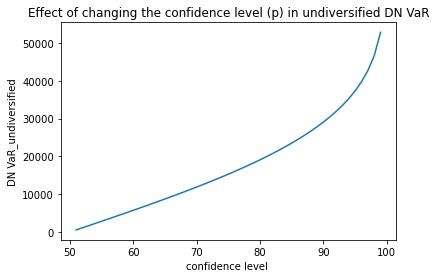

In [36]:
confidence_level_lst = [ (i+1) for i in range(50,99) ]

VaR_u = [ ]  
for confidence_level in confidence_level_lst:
    VaR_u.append(undiversified_d_day_p_percent_VaR_delta_normal_fx(df_lst=FX_portA, F_lst=F_lstA, d=1, p= confidence_level, ewma_par_lst=None))

plt.plot( confidence_level_lst , VaR_u )
plt.xlabel( 'confidence level ' )
plt.ylabel( 'DN VaR_undiversified' )
plt.title("Effect of changing the confidence level (p) in undiversified DN VaR")
plt.show()

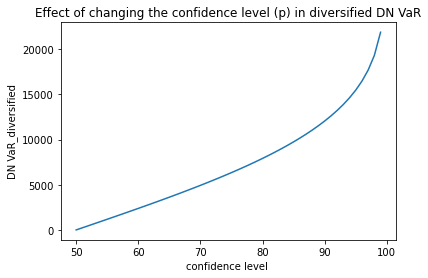

In [44]:
confidence_level_lst = [ (i+1) for i in range(49,99) ]

VaR_u = [ ]  
for confidence_level in confidence_level_lst:
    VaR_u.append( diversified_d_day_p_percent_VaR_delta_normal_fx(
        df_lst = FX_portA,
        F_lst  = F_lstA,
        d = 1,p= confidence_level,
        ewma_par_lst=None,
        covar_ewma_par=None))

plt.plot( confidence_level_lst , VaR_u )
plt.xlabel( 'confidence level ' )
plt.ylabel( 'DN VaR_diversified' )
plt.title("Effect of changing the confidence level (p) in diversified DN VaR")
plt.show()

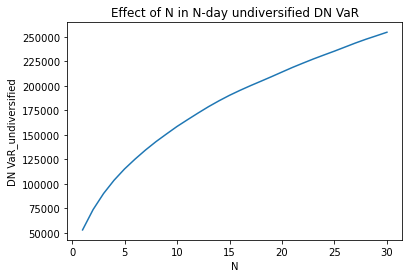

In [49]:
N_lst = [ i+1 for i in range(0,30) ]

VaR_u = [ ]  
for d in N_lst:
    VaR_u.append( undiversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst=FX_portA,
    F_lst=F_lstA,
    d=d, p= 99, ewma_par_lst=None))

plt.plot( N_lst , VaR_u )
plt.xlabel( 'N' )
plt.ylabel( 'DN VaR_undiversified' )
plt.title("Effect of N in N-day undiversified DN VaR")
plt.show()

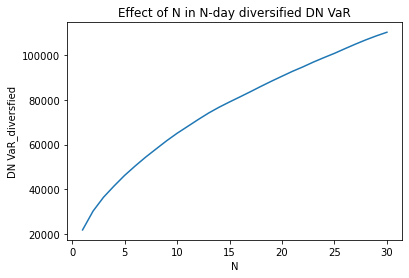

In [50]:
N_lst = [ i+1 for i in range(0,30) ]

VaR_d = [ ]  
for d in N_lst:
    VaR_d.append( diversified_d_day_p_percent_VaR_delta_normal_fx(
    df_lst=FX_portA,
    F_lst=F_lstA,
    d=d, p= 99, ewma_par_lst=None))

plt.plot( N_lst , VaR_d )
plt.xlabel( 'N' )
plt.ylabel( 'DN VaR_diversfied' )
plt.title("Effect of N in N-day diversified DN VaR")
plt.show()

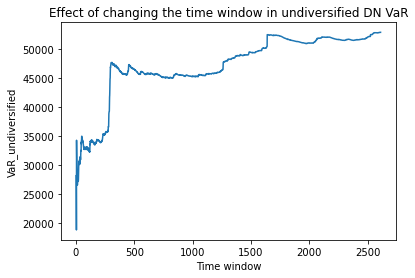

In [28]:
pd.options.mode.chained_assignment = None 

FX_portA1 = [ [ df.iloc[0:(i+2),:] for df in FX_portA ] for i in range(2610) ]
VaR_u = []
for d in range(2610):
    VaR_u.append(undiversified_d_day_p_percent_VaR_delta_normal_fx(df_lst = FX_portA1[d], F_lst = F_lstA,d=1, p= 99))
    
plt.plot( [ i+1 for i in range(2610)], VaR_u )
plt.xlabel('Time window')
plt.ylabel('VaR_undiversified')
plt.title("Effect of changing the time window in undiversified DN VaR")
plt.show()

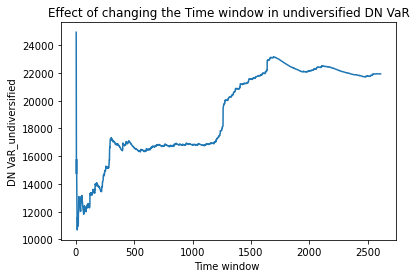

In [32]:
pd.options.mode.chained_assignment = None 

FX_portA1 = [ [ df.iloc[0:i+3,:] for df in FX_portA ] for i in range(2609) ]

VaR_d = []
for d in range(2609):
    VaR_d.append(diversified_d_day_p_percent_VaR_delta_normal_fx(df_lst = FX_portA1[d], F_lst=F_lstA,d=1, p=99))

plt.plot( [i+2 for i in range(2609)], VaR_d )
plt.xlabel( 'Time window ' )
plt.ylabel( 'DN VaR_undiversified' )
plt.title("Effect of changing the Time window in undiversified DN VaR")
plt.show()

#### 2. VARYING THE PARAMETERS IN THE HS APPROACH

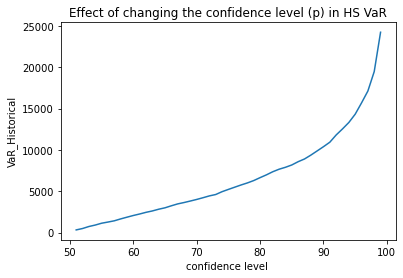

In [45]:
confidence_level_lst = [ (i+1) for i in range(50,99) ]

VaR_u = [ ]  
for confidence_level in confidence_level_lst:
    VaR_u.append( VaR_hs_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=1, p= confidence_level))

plt.plot( confidence_level_lst , VaR_u )
plt.xlabel( 'confidence level ' )
plt.ylabel( 'VaR_Historical' )
plt.title("Effect of changing the confidence level (p) in HS VaR")
plt.show()

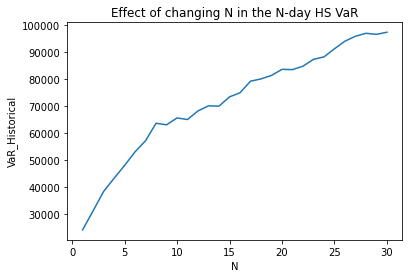

In [51]:
N_lst = [ i+1 for i in range(0,30) ]

VaR_hs = [ ]  
for d1 in N_lst:
    VaR_hs.append( VaR_hs_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=d1, p= 99) )
    
plt.plot( N_lst , VaR_hs)
plt.xlabel( 'N' )
plt.ylabel( 'VaR_Historical' )
plt.title("Effect of changing N in the N-day HS VaR")
plt.show()

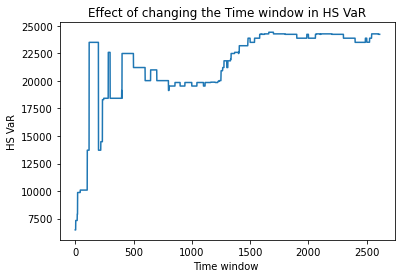

In [30]:
FX_portA1 = [ [ df.iloc[0:i+2,:] for df in FX_portA ] for i in range(2610) ]

VaR_h = []
for d in range(2610):
    VaR_h.append( VaR_hs_fx( df_lst= FX_portA1[d],  F_lst= F_lstA,  d=1, p= 99) )

plt.plot( [i+1 for i in range(2610)], VaR_h )
plt.xlabel( 'Time window ' )
plt.ylabel( 'HS VaR' )
plt.title("Effect of changing the Time window in HS VaR")
plt.show()

#### 3. VARYING THE PARAMETERS IN THE BRW APPROACH (Recheck)

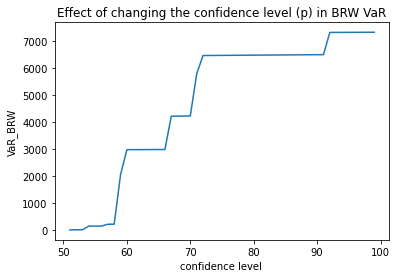

In [48]:
confidence_level_lst = [ (i+1) for i in range(50,99) ]

VaR_u = [ ]  
for confidence_level in confidence_level_lst:
    VaR_u.append( VaR_brw_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=1, p=confidence_level, decay_par = 0.8))

plt.plot( confidence_level_lst , VaR_u )
plt.xlabel( 'confidence level ' )
plt.ylabel( 'VaR_BRW' )
plt.title("Effect of changing the confidence level (p) in BRW VaR")
plt.show()

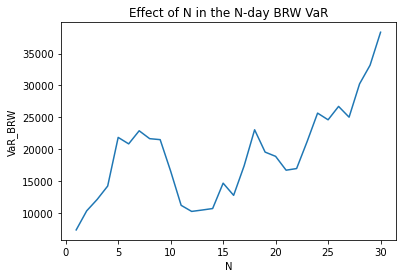

In [52]:
N_lst = [ i+1 for i in range(0,30) ]

VaR_u = [ ]  
for d in N_lst:
    VaR_u.append( VaR_brw_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=d, p= 99, decay_par = 0.8))

plt.plot( N_lst , VaR_u )
plt.xlabel( 'N' )
plt.ylabel( 'VaR_BRW' )
plt.title("Effect of N in the N-day BRW VaR")
plt.show()

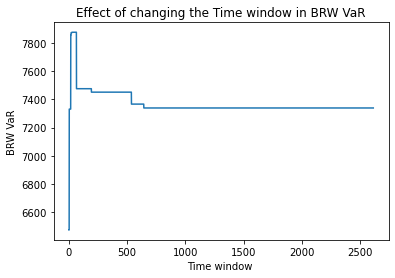

In [66]:
pd.options.mode.chained_assignment = None 

FX_portA1 = [ [ df.iloc[0:i+3,:] for df in FX_portA ] for i in range(2609) ]

VaR_brw = []
for d in range(2609):
    VaR_brw.append(VaR_brw_fx(
    df_lst= FX_portA1[d], 
    F_lst= F_lstA, 
    d=1, p= 99, decay_par = 0.8) )

plt.plot( [i+3 for i in range(2609)], VaR_brw )
plt.xlabel( 'Time window ' )
plt.ylabel( 'BRW VaR' )
plt.title("Effect of changing the Time window in BRW VaR")
plt.show()

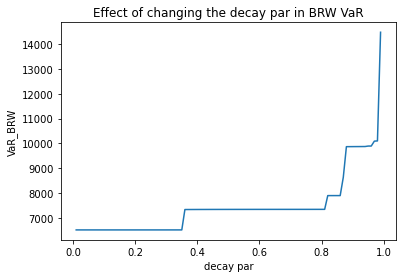

In [71]:
DP_lst = [ (i+1)/100 for i in range(0,99) ]

VaR_brw = [ ]  
for decay_par in DP_lst:
    VaR_brw.append( VaR_brw_fx(
    df_lst= FX_portA, 
    F_lst= F_lstA, 
    d=1, p= 99, decay_par = decay_par))

plt.plot( DP_lst , VaR_brw )
plt.xlabel( 'decay par' )
plt.ylabel( 'VaR_BRW' )
plt.title("Effect of changing the decay par in BRW VaR")
plt.show()

#### ANALYSES (INSUFFICIENT)

Based on our sensitivity analysis, the best method that would capture the market risk of Portfolio A is the BRW approach. Notice in the among the graphs across three approaches, the trends in the BRW section are more stable. This indicates how BRW is consistent in predicting the market risk. Unlike in other graphs where the trends are more random, the graphs in BRW are stable regardless of the parameters we vary.

### Question B on Bonds
Consider **Portfolio C** and its undiversified 10-day 99% VaR which you calculated using Delta-Normal Approach in Part 2.

Which of the four bonds in the fixed-income portfolio has the highest contribution to the undiversified 10-day 99% VaR? Why? Compare the individual VaRs and determine which factors and bond features led to the bond's high VaR contribution. Explore and discuss the effect of these factors and features to the resulting VaR.

In [39]:
def get_factors_d_day_p_percent_VaR_delta_normal_bonds(df, d, p, 
    face_value_lst, start_date, maturity_date_lst, coupon_rate_lst, 
    coupon_freq_lst
):
    """
    This function helps answer Question B of Part 3. The specifications in 'undiversified_d_day_p_percent_VaR_delta_normal_bonds' also
    appplies here. This returns some key factors needed to compute for an individual VaR of each bond in a portfolio.
    """
    
    #create the list of ytm for the DV01 computation
    ytm_lst= np.array(Bond_portC.iloc[0:1,1:].values.flatten().tolist())/100

    #solve for the DV01 of each bobond
    DV01_lst = []
    for face_value, maturity_date, coupon_rate, coupon_freq, ytm in zip(face_value_lst,maturity_date_lst,coupon_rate_lst,coupon_freq_lst,ytm_lst):
        dv01 = get_DV01(start_date, maturity_date, face_value, coupon_rate, coupon_freq, ytm)
        DV01_lst.append(dv01)
        
    #create a df of log(returns) of yields of each bond
    for column in df:
        df_shifted    = df.shift(-d)
        df_logreturns = np.log(df.iloc[:,1:]/df_shifted.iloc[:,1:])
        df_std        = np.array(df_logreturns.std())
        
    quantile = NormalDist().inv_cdf(p)
    VaR = 100**2 * df_std * DV01_lst * ytm_lst * quantile
        
    return ytm_lst, DV01_lst, df_std, VaR

In [40]:
ytm_lst= np.array(Bond_portC.iloc[0:1,1:].values.flatten().tolist())/100

face_value_lst    = [1000000,1000000,1000000,1000000] 
start_date        = "2022-10-03"
maturity_date_lst = ["2027-12-31","2023-06-01","2035-01-15","2030-09-28"]
coupon_rate_lst   = [0.08,0.075,0.06,0]
coupon_freq_lst   = [1,2,4,0]

ytm_lst, DV01_lst, df_std,VaR = get_factors_d_day_p_percent_VaR_delta_normal_bonds(Bond_portC,10,0.99, face_value_lst=[1000000,1000000,1000000,1000000], 
    start_date="2022-10-03", maturity_date_lst=["2027-12-31","2023-06-01","2035-01-15","2030-09-28"], 
    coupon_rate_lst=[0.08,0.075,0.06,0], coupon_freq_lst=[1,2,4,0])

row_names = ["Bond","y0", "DV01", "STD", "VaR"]
bond_names =  ["Roquefort","Camembert","Feta","Gouda"]
data       =  zip(bond_names,ytm_lst, DV01_lst, df_std,VaR)
print("Table 2. Factors that Affect VaR of Each Bond")
print(tabulate(data,headers=row_names,tablefmt="fancy_grid"))

Table 2. Factors that Affect VaR of Each Bond
╒═══════════╤═════════╤══════════╤═══════════╤═══════════╕
│ Bond      │      y0 │     DV01 │       STD │       VaR │
╞═══════════╪═════════╪══════════╪═══════════╪═══════════╡
│ Roquefort │ 0.07667 │ 453.713  │ 0.0128401 │ 10390.8   │
├───────────┼─────────┼──────────┼───────────┼───────────┤
│ Camembert │ 0.07475 │  66.6719 │ 0.0042675 │   494.768 │
├───────────┼─────────┼──────────┼───────────┼───────────┤
│ Feta      │ 0.06176 │ 861.159  │ 0.0156417 │ 19353.1   │
├───────────┼─────────┼──────────┼───────────┼───────────┤
│ Gouda     │ 0.0297  │ 500.733  │ 0.0304233 │ 10525.5   │
╘═══════════╧═════════╧══════════╧═══════════╧═══════════╛


Considering Table 2, the following observations are made:
1. It is clear that the bond Feta has the highest contribution to the undiversified 10-day 99% VaR with approximately **38,495.80**. Mainly, this can be attributed to its high DV01. 

    1.1. In fact, the ranking of the bonds in terms of VaR follows that of DV01 and STD. This is congruent to the definition of these two concepts since VaR is directly linked to the concept of duration in situations where a portfolio is exposed to one risk factor only, the interest rate. Duration measures the exposure to the risk facto while VaR incorporates duration with the probability of an adverse move in the interest rate (Jorion, n.d).
  
  2) Meanwhile, the VaR of Roquefort and Gouda were relatively close but Gouda had a higher VaR because it has a greater DV01 and standard deviation of log returns. 
  3) Camembert, clearly, has the lowest VaR since it has a very low DV01 and standard deviation of log returns. It may have one of the highest recent yield (y0) but the mentioned factors were too low compared to pull up its VaR.